# Feature Engineering
In this chapter learn how to create new features for your machine learning model to learn from. We'll look at generating them by combining fields, extracting values from messy columns or encoding them for better results.

## Differences
Let's explore generating features using existing ones. In the midwest of the U.S. many single family homes have extra land around them for green space. In this example you will create a new feature called 'YARD_SIZE', and then see if the new feature is correlated with our outcome variable.

In [1]:
!aws s3 cp s3://qa.dssa.thetradedesk.com/libs/playground_py36.zip ../libs/playground_py36.zip

from utils.start_session import *

download: s3://qa.dssa.thetradedesk.com/libs/playground_py36.zip to ../libs/playground_py36.zip
No existing SparkSession


In [2]:
# File Path
file_path = "s3a://qa.dssa.thetradedesk.com/data/datacamp/"

# Read the file into a dataframe
df = spark.read.parquet(file_path + 'real_estate')

# Lot size in square feet
acres_to_sqfeet = 43560
df = df.withColumn('LOT_SIZE_SQFT', df['ACRES'] * acres_to_sqfeet)

# Create new column YARD_SIZE
df = df.withColumn('YARD_SIZE', df['LOT_SIZE_SQFT'] - df['FOUNDATIONSIZE'])

# Corr of ACRES vs SALESCLOSEPRICE
print("Corr of ACRES vs SALESCLOSEPRICE: " + str(df.corr('YARD_SIZE', 'SALESCLOSEPRICE')))
# Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE
print("Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: " + str(df.corr('FOUNDATIONSIZE', 'SALESCLOSEPRICE')))
# Corr of YARD_SIZE vs SALESCLOSEPRICE
print("Corr of YARD_SIZE vs SALESCLOSEPRICE: " + str(df.corr('LOT_SIZE_SQFT', 'SALESCLOSEPRICE')))

Corr of ACRES vs SALESCLOSEPRICE: 0.20702156459843227
Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: 0.6159889363733617
Corr of YARD_SIZE vs SALESCLOSEPRICE: 0.22049164610781719


Not all generated features are worthwhile, many are not but its still worth doing! Most likely this is because there isn't a lot of variation in lot sizes in the neighborhoods we are looking at to create a strong feature. In addition if we look at our data, some of the homes have 0 ACRES if we really wanted to handle this correctly we could have to set the minimum YARD_SIZE to 0.

## Ratios
Ratios are all around us. Whether it's miles per gallon or click through rate, they are everywhere. In this exercise, we'll create some ratios by dividing out pairs of columns.

In [3]:
# ASSESSED_TO_LIST
df = df.withColumn('ASSESSED_TO_LIST', df['ASSESSEDVALUATION'] / df[
    'LISTPRICE'])
df[['ASSESSEDVALUATION', 'LISTPRICE', 'ASSESSED_TO_LIST']].show(5)
# TAX_TO_LIST
df = df.withColumn('TAX_TO_LIST', df['TAXES'] / df[
    'LISTPRICE'])
df[['TAX_TO_LIST', 'TAXES', 'LISTPRICE']].show(5)
# BED_TO_BATHS
df = df.withColumn('BED_TO_BATHS', df['BEDROOMS'] / df[
    'BATHSTOTAL'])
df[['BED_TO_BATHS', 'BEDROOMS', 'BATHSTOTAL']].show(5)

+-----------------+---------+--------------------+
|ASSESSEDVALUATION|LISTPRICE|    ASSESSED_TO_LIST|
+-----------------+---------+--------------------+
|             58.0|   279900|2.072168631654162E-4|
|            205.0|   299900|6.835611870623542E-4|
|              0.0|   219900|                 0.0|
|            743.0|   199900|0.003716858429214...|
|             54.0|   224900|2.401067140951534E-4|
+-----------------+---------+--------------------+
only showing top 5 rows

+--------------------+-----+---------+
|         TAX_TO_LIST|TAXES|LISTPRICE|
+--------------------+-----+---------+
|0.011461236155769917| 3208|   279900|
|0.012740913637879292| 3821|   299900|
|0.013960891314233743| 3070|   219900|
|0.012211105552776389| 2441|   199900|
|0.011916407292129836| 2680|   224900|
+--------------------+-----+---------+
only showing top 5 rows

+------------------+--------+----------+
|      BED_TO_BATHS|BEDROOMS|BATHSTOTAL|
+------------------+--------+----------+
|1.33333333333333

Well done, we've created some great ratios to use in our model that people looking at homes might be considering! Often times rather than just hoping that features will be important and trying them all brute force its more worthwhile to talk to someone that knows the context to get ideas!

## Deeper Features
In previous exercises we showed how combining two features together can create good additional features for a predictive model. In this exercise, you will generate 'deeper' features by combining the effects of three variables into one. Then you will check to see if deeper and more complicated features always make for better predictors.

In [4]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} seaborn

from matplotlib import pyplot as plt
import seaborn as sns

Solving environment: done

# All requested packages already installed.



In [5]:
from scipy import stats

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

+-------+-------------------+
|summary| BATHS_PER_1000SQFT|
+-------+-------------------+
|  count|               4974|
|   mean| 1.4314316436808154|
| stddev| 14.165765742816745|
|    min|0.39123630672926446|
|    max|             1000.0|
+-------+-------------------+



/home/hadoop/anaconda/envs/playground_py36/lib/python3.6/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


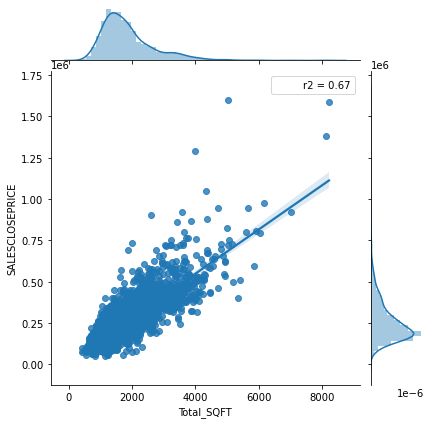

/home/hadoop/anaconda/envs/playground_py36/lib/python3.6/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


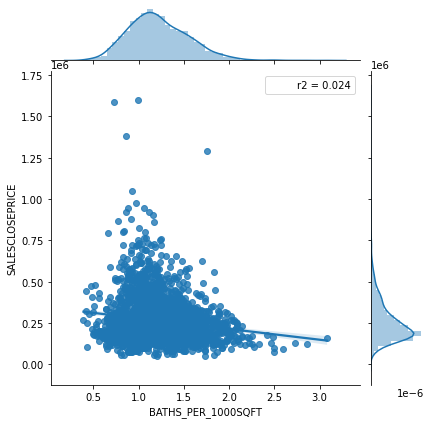

In [6]:
# Create new feature by adding two features together
df = df.withColumn('Total_SQFT', df['SQFTBELOWGROUND'] + df['SQFTABOVEGROUND'])

# Create additional new feature using previously created feature
df = df.withColumn('BATHS_PER_1000SQFT', df['BATHSTOTAL'] / (df['Total_SQFT'] / 1000))
df[['BATHS_PER_1000SQFT']].describe().show()

# Sample and create pandas dataframe
pandas_df = df.sample(False, 0.5, 0).toPandas()

# Linear model plots
sns.jointplot(x='Total_SQFT', y='SALESCLOSEPRICE', data=pandas_df, kind="reg", stat_func=r2)
plt.show()
sns.jointplot(x='BATHS_PER_1000SQFT', y='SALESCLOSEPRICE', data=pandas_df, kind="reg", stat_func=r2)
plt.show()

Using the describe() function you could have seen there was a max of 1000 bathrooms per 1000sqft, which is almost for sure an issue with our data since no sane person would need a bathroom for square foot! If you really wanted to use this feature you'd have to filter that outlier out or overwrite it to NULL with when(). After plotting the jointplots()s you should have seen that the less complicated feature Total_SQFT had a much better R**2 of .67 vs BATHS_PER_1000SQFT's .02'. Often simplier is better!

## Time Components
Being able to work with time components for building features is important but you can also use them to explore and understand your data further. In this exercise, you'll be looking to see if there is a pattern to which day of the week a house lists on. Please keep in mind that PySpark's week starts on Sunday, with a value of 1 and ends on Saturday, a value of 7.

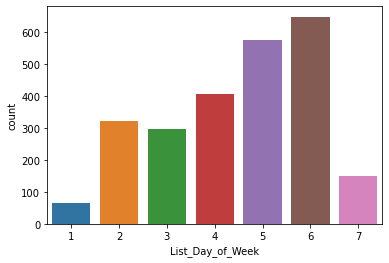

In [7]:
# Import needed functions
from pyspark.sql.functions import to_date, dayofweek, substring_index

# Convert to date type
df = df.withColumn('LISTDATE', substring_index("LISTDATE", " ", 1)) \
    .withColumn('LISTDATE', to_date('LISTDATE', 'M/dd/yy')) 

# Get the day of the week
df = df.withColumn('List_Day_of_Week', dayofweek('LISTDATE'))

# Sample and convert to pandas dataframe
sample_df = df.sample(False, 0.5, 42).toPandas()

# Plot count plot of of day of week
sns.countplot(x="List_Day_of_Week", data=sample_df)
plt.show()

Fantastic, using these time components and some visualization techniques from earlier we can see its pretty unlikely to list a home on the weekend (Values 1 and 7).

## Joining On Time Components
Often times you will use date components to join in other sets of information. However, in this example, we need to use data that would have been available to those considering buying a house. This means we will need to use the previous year's reporting data for our analysis.

In [8]:
from pyspark.sql.functions import year

# Initialize dataframes
price_df = spark.createDataFrame(sc.parallelize([
    ('LELM - Lake Elmo' , 401000 , 2016), 
    ('MAPW - Maplewood' , 193000 , 2016),
    ('STP - Saint Paul' , 172000 , 2016),
    ('WB - Woodbury' , 291000 , 2016),
    ('OAKD - Oakdale' , 210000 , 2016),
    ('LELM - Lake Elmo' , 385000 , 2015),
    ('MAPW - Maplewood' , 187000 , 2015),
    ('STP - Saint Paul' , 162000 , 2015),
    ('WB - Woodbury' , 277000 , 2015),
    ('OAKD - Oakdale' , 192000 , 2015)
]), schema=['CITY', 'MedianHomeValue', 'Year'])


# Create year column
df = df.withColumn('list_year', year('LISTDATE'))

# Adjust year to match
df = df.withColumn('report_year', (df['list_year'] - 1))

# Create join condition
condition = [df['CITY'] == price_df['CITY'], df['report_year'] == price_df['Year']]

# Join the dataframes together
df = df.join(price_df, on=condition, how='left')
# Inspect that new columns are available
df[['MedianHomeValue']].show(5)

+---------------+
|MedianHomeValue|
+---------------+
|         291000|
|         291000|
|         291000|
|         291000|
|         291000|
+---------------+
only showing top 5 rows



Great work. You can see how easy it is to join data that is reported out at different intervals to use in your data. You also can see how easy it is to use data that would not have been available at the time of someone buying a home; a form of data leakage.

## Date Math
In this example, we'll look at verifying the frequency of our data. The Mortgage dataset is supposed to have weekly data but let's make sure by lagging the report date and then taking the difference of the dates.

Recall that to create a lagged feature we will need to create a window(). window() allows you to return a value for each record based off some calculation against a group of records, in this case, the previous period's mortgage rate.

In [9]:
from pyspark.sql.types import *
from pyspark.sql.functions import lag, datediff, to_date
from pyspark.sql.window import Window

# Load in data
mort_df = spark.read \
    .schema(StructType([StructField('DATE', StringType(), True), StructField('MORTGAGE30US', DoubleType(), True)])) \
    .csv(file_path + 'mortgage', header=True) \
    .repartition(500)

# Cast data type
mort_df = mort_df.withColumn('DATE', to_date('DATE'))

# Create window
w = Window().orderBy(mort_df['DATE'])
# Create lag column
mort_df = mort_df.withColumn('DATE-1', lag('DATE', count=1).over(w))

# Calculate difference between date columns
mort_df = mort_df.withColumn('Days_Between_Report', datediff('DATE', 'DATE-1'))
# Print results
mort_df.select('Days_Between_Report').distinct().show(5)

+-------------------+
|Days_Between_Report|
+-------------------+
|               null|
|                  7|
|                  6|
|                  8|
+-------------------+



## Extracting Text to New Features
Garages are an important consideration for houses in Minnesota where most people own a car and the snow is annoying to clear off a car parked outside. The type of garage is also important, can you get to your car without braving the cold or not? Let's look at creating a feature has_attached_garage that captures whether the garage is attached to the house or not.

In [10]:
# Import needed functions
from pyspark.sql.functions import when

# Read the file into a dataframe
df = spark.read.parquet(file_path + 'real_estate')

# Create boolean conditions for string matches
has_attached_garage = df['GARAGEDESCRIPTION'].like('%Attached Garage%')
has_detached_garage = df['GARAGEDESCRIPTION'].like('%Detached Garage%')

# Conditional value assignment 
df = df.withColumn('has_attached_garage', (when(has_attached_garage, 1)
                                          .when(has_detached_garage, 0)
                                          .otherwise(None)))

# Inspect results
df[['GARAGEDESCRIPTION', 'has_attached_garage']].show(5, truncate=100)

+---------------------------------------------------+-------------------+
|                                  GARAGEDESCRIPTION|has_attached_garage|
+---------------------------------------------------+-------------------+
|                                    Attached Garage|                  1|
|                                    Detached Garage|                  0|
|                Attached Garage, Driveway - Asphalt|                  1|
|                                    Detached Garage|                  0|
|Detached Garage, Uncovered/Open, Garage Door Opener|                  0|
+---------------------------------------------------+-------------------+
only showing top 5 rows



## Splitting & Exploding
Being able to take a compound field like GARAGEDESCRIPTION and massaging it into something useful is an involved process. It's helpful to understand early what value you might gain out of expanding it. In this example, we will convert our string to a list-like array, explode it and then inspect the unique values.

In [11]:
# Import needed functions
from pyspark.sql.functions import split, explode

# Convert string to list-like array
df = df.withColumn('garage_list', split(df['GARAGEDESCRIPTION'], ', '))

# Explode the values into new records
ex_df = df.withColumn('ex_garage_list', explode(df['garage_list']))

# Inspect the values
ex_df[['ex_garage_list']].distinct().show(100, truncate=50)

+----------------------------+
|              ex_garage_list|
+----------------------------+
|           Driveway - Gravel|
|          Underground Garage|
|                       Other|
|                    Assigned|
|   No Int Access to Dwelling|
|       Contract Pkg Required|
|                     Secured|
|          Driveway - Asphalt|
|             Attached Garage|
|                        None|
| More Parking Onsite for Fee|
|      On-Street Parking Only|
|          Garage Door Opener|
|           Driveway - Shared|
|                  Unassigned|
|                  Units Vary|
|                      Tandem|
|              Uncovered/Open|
|             Detached Garage|
|                   Tuckunder|
|       Valet Parking for Fee|
|    Driveway - Other Surface|
|         Driveway - Concrete|
|               Heated Garage|
|            Insulated Garage|
|More Parking Offsite for Fee|
|                     Carport|
|                     Covered|
+----------------------------+



Great, looking at the values, it looks like there is a decent amount of values here but not hundreds. If you have too many, when you pivot them it can make your dataset a mess.

## Pivot & Join
Being able to explode and pivot a compound field is great, but you are left with a dataframe of only those pivoted values. To really be valuable you'll need to rejoin it to the original dataset! After joining the datasets we will have a lot of NULL values for the newly created columns since we know the context of how they were created we can safely fill them in with zero as either the new has an attribute or it doesn't.

In [12]:
from pyspark.sql.functions import coalesce, first, lit

# Create a dummy column of constant value
ex_df = ex_df.withColumn('constant_val', lit(1))

# Pivot 
piv_df = ex_df.groupBy('NO').pivot('ex_garage_list').agg(coalesce(first('constant_val')))

# Join the dataframes together and fill null
joined_df = df.join(piv_df, on='NO', how='left')

# Columns to zero fill
zfill_cols = piv_df.columns

# Zero fill the pivoted values
zfilled_df = joined_df.fillna(0, subset=zfill_cols)

Fantastic, you now have a bunch of boolean columns created from the single compound field. Hopefully some of these will be valuable in our model!

## Binarizing Day of Week
In a previous video, we saw that it was very unlikely for a home to list on the weekend. Let's create a new field that says if the house is listed for sale on a weekday or not. In this example there is a field called List_Day_of_Week that has Monday is labeled 1.0 and Sunday is 7.0. Let's convert this to a binary field with weekday being 0 and weekend being 1. We can use the pyspark feature transformer Binarizer to do this.

In [13]:
# Import transformer
from pyspark.ml.feature import Binarizer

# Convert to date type
df = df.withColumn('LISTDATE', substring_index("LISTDATE", " ", 1)) \
    .withColumn('LISTDATE', to_date('LISTDATE', 'M/dd/yy')) \
    .withColumn('List_Day_of_Week', dayofweek('LISTDATE')) 

df = df.withColumn('List_Day_of_Week', df['List_Day_of_Week'].cast('double'))

# Create the transformer
binarizer = Binarizer(threshold=5.0, inputCol='List_Day_of_Week', outputCol='Listed_On_Weekend')

# Apply the transformation to df
df = binarizer.transform(df)

# Verify transformation
df[['List_Day_of_Week', 'Listed_On_Weekend']].show(5)

+----------------+-----------------+
|List_Day_of_Week|Listed_On_Weekend|
+----------------+-----------------+
|             2.0|              0.0|
|             6.0|              1.0|
|             5.0|              0.0|
|             7.0|              1.0|
|             6.0|              1.0|
+----------------+-----------------+
only showing top 5 rows



Well done, transforming features with binarize is helpful in creating more powerful features, in both explainability of your model and performance.

## Bucketing
If you are a homeowner its very important if a house has 1, 2, 3 or 4 bedrooms. But like bathrooms, once you hit a certain point you don't really care whether the house has 7 or 8. This example we'll look at how to figure out where are some good value points to bucket.

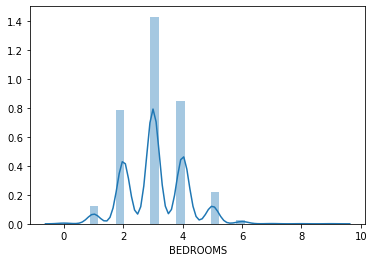

+--------+--------+
|BEDROOMS|bedrooms|
+--------+--------+
|     4.0|     4.0|
|     4.0|     4.0|
|     4.0|     4.0|
|     2.0|     2.0|
|     3.0|     3.0|
+--------+--------+
only showing top 5 rows



In [14]:
from pyspark.ml.feature import Bucketizer

df = df.withColumn('BEDROOMS', df['BEDROOMS'].cast('bigint'))

# Sample and convert to pandas dataframe
sample_df = df.select("BEDROOMS").sample(False, 0.5, 42).toPandas()

# Plot distribution of sample_df
sns.distplot(sample_df, axlabel='BEDROOMS')
plt.show()

# Create the bucket splits and bucketizer
splits = [0, 1, 2, 3, 4, 5, float('Inf')]
buck = Bucketizer(splits=splits, inputCol='BEDROOMS', outputCol='bedrooms')

# Apply the transformation to df: df_bucket
df_bucket = buck.transform(df)

# Display results
df_bucket[['BEDROOMS', 'bedrooms']].show(5)

Being able to inspect a distribution plot is important if you are considering bucketing feature values together. Here we saw that after 5 bathrooms it was exceedingly rare, so we could combine either effects together in a 5+ value.

## One Hot Encoding
In the United States where you live determines which schools your kids can attend. Therefore it's understandable that many people care deeply about which school districts their future home will be in. While the school districts are numbered in SCHOOLDISTRICTNUMBER they are really categorical. Meaning that summing or averaging these values has no apparent meaning. Therefore in this example we will convert SCHOOLDISTRICTNUMBER from a categorial variable into a numeric vector to use in our machine learning model later.

In [15]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

# Map strings to numbers with string indexer
string_indexer = StringIndexer(inputCol='SCHOOLDISTRICTNUMBER', outputCol='School_Index')
indexed_df = string_indexer.fit(df).transform(df)

# Onehot encode indexed values
encoder = OneHotEncoder(inputCol='School_Index', outputCol='School_Vec')
encoded_df = encoder.transform(indexed_df)

# Inspect the transformation steps
encoded_df[['SCHOOLDISTRICTNUMBER', 'School_Index', 'School_Vec']].show(5, truncate=100)

+-----------------------------+------------+-------------+
|         SCHOOLDISTRICTNUMBER|School_Index|   School_Vec|
+-----------------------------+------------+-------------+
|               625 - St. Paul|         0.0|(7,[0],[1.0])|
|               625 - St. Paul|         0.0|(7,[0],[1.0])|
|622 - North St Paul-Maplewood|         1.0|(7,[1],[1.0])|
|622 - North St Paul-Maplewood|         1.0|(7,[1],[1.0])|
|               625 - St. Paul|         0.0|(7,[0],[1.0])|
+-----------------------------+------------+-------------+
only showing top 5 rows



Well done! One Hot Encoding is a great way to handle categorial variables. You may have noticed that the implementation in PySpark is different than Pandas get_dummies() as it puts everything into a single column of type vector rather than a new column for each value. It's also different from sklearn's OneHotEncoder in that the last categorical value is captured by a vector of all zeros.